# Load Libraries

In [20]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import joblib
import json
import csv
import pathlib
import librosa
import librosa.display
import scipy.stats
from scipy.stats import skew, kurtosis
from scipy.signal import hilbert

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from PIL import Image
from matplotlib import pyplot
from collections import Counter
from pydub import AudioSegment # sudo apt install ffmpeg
from pprint import pprint
%matplotlib inline

from concurrent.futures import ThreadPoolExecutor

In [21]:
# !pip3 install keras --break-system-packages
# !pip3 install tensorflow --break-system-packages
# !pip3 install imbalanced-learn --break-system-packages
# !pip3 install seaborn --break-system-packages

In [22]:
# !pip install numpy==1.22

In [23]:
import numpy as np
print(np.__version__)

1.26.4


# Load data

In [24]:
df_all = pd.read_csv('Results/Data/data_all.csv')
df_all

,dataset,filepath,filename,age,gender,label,status,prob
0,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_counting-normal,28.0,male,0,healthy,NaN
1,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_vowel-o,28.0,male,0,healthy,NaN
2,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_vowel-a,28.0,male,0,healthy,NaN
3,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_vowel-e,28.0,male,0,healthy,NaN
4,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_breathing-shallow,28.0,male,0,healthy,NaN
...,...,...,...,...,...,...,...,...
72335,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-097-cough-m-37-8.wav,37.0,male,1,negative,NaN
72336,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-097-cough-m-37-9.wav,37.0,male,1,negative,NaN
72337,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-098-cough-f-24-1.wav,24.0,female,1,negative,NaN
72338,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-098-cough-f-24-0.wav,24.0,female,1,negative,NaN


In [25]:
Counter(df_all['dataset'].tolist())

Counter({'coughvid': 34434,
         'coswara': 24712,
         'fsdkaggle': 11073,
         'esc50': 2000,
         'virufy': 121})

# Get Durations

In [26]:
# cmap = plt.get_cmap('inferno')

# list_dataset_name = ['coswara', 'coughvid', 'esc50', 'fsdkaggle', 'virufy']

# for dataset_name in list_dataset_name:
#     print(dataset_name)
#     df_all = pd.read_csv(f'Results/Data/data_summary_{dataset_name}.csv')
#     path_save = f'Results/Preprocess/data_{dataset_name}_preprocess.csv'
    
#     if os.path.exists(path_save) == False:
    
#         list_duration = []
#         for i in tqdm(range(0, len(df_all))): 
#             ############################################################
#             # Get df data
#             ############################################################
#             filepath = df_all['filepath'][i] # Audio path
#             dataset = df_all['dataset'][i] # Dataset name
#             filename = df_all['filename'][i]

#             try:
#                 ############################################################
#                 # Load signal and sample frequency
#                 ############################################################
#                 (y, sr) = librosa.load(filepath, mono=True)
                
#                 ############################################################
#                 # Get duration
#                 ############################################################
#                 duration = librosa.get_duration(y=y, sr=sr)
#                 list_duration.append(duration)
                
#                 ############################################################
#                 # Plot specgram
#                 ############################################################
#                 # plt.figure(figsize=(6, 3))  # Width=6 inches, Height=4 inches
                
#                 # plt.specgram(
#                 #     y, 
#                 #     NFFT=2048, 
#                 #     Fs=sr,
#                 #     # Fs=2, 
#                 #     Fc=0, 
#                 #     noverlap=128, 
#                 #     cmap='magma', 
#                 #     sides='default', 
#                 #     mode='default', 
#                 #     scale='dB')
                
#                 # plt.xlabel('Time (s)')
#                 # plt.ylabel('Frequency (Hz)')
#                 # plt.title('Spectrogram')
#                 # plt.colorbar(label='Intensity (dB)')
                
#                 # title = f"{dataset}\n{filename}"
#                 # plt.title(title)    
#                 # plt.show()
                
#             except Exception as error:
#                 print('#'*50)
#                 print('Source:', filepath)
#                 print('Dataset:', dataset)
#                 print('Filename:', filename)
#                 print(error)
                
#         df_all['duration'] = list_duration
#         df_all.to_csv(path_save, index=False)

# Extract Features

We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [27]:
# Get columns
columns = [
    'dataset', 'filepath', 'filename', 
    'age', 'gender', 'label', 'status', 'duration', 
    'duration_segment', 'sample_frequency',
    
    'mean', 'variance', 'std_dev', 'max_value', 'min_value', 'rms',
    'skewness', 'kurtosis', 'median', 'range_val', 'iqr',
    
    'zcr', 'energy', 'rmse', 'entropy',
    
    'spectral_centroid',
    'spectral_bandwidth',
    'spectral_contrast',
    'spectral_flatness',
    'spectral_rolloff',

    'chroma_stft',
    ]

# MFCC
for i in range(1, 21):
    columns.append(f'mfcc_mean_{i}_mean')
    columns.append(f'mfcc_mean_{i}_median')
    columns.append(f'mfcc_{i}_std')
    
print(columns)

['dataset', 'filepath', 'filename', 'age', 'gender', 'label', 'status', 'duration', 'duration_segment', 'sample_frequency', 'mean', 'variance', 'std_dev', 'max_value', 'min_value', 'rms', 'skewness', 'kurtosis', 'median', 'range_val', 'iqr', 'zcr', 'energy', 'rmse', 'entropy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast', 'spectral_flatness', 'spectral_rolloff', 'chroma_stft', 'mfcc_mean_1_mean', 'mfcc_mean_1_median', 'mfcc_1_std', 'mfcc_mean_2_mean', 'mfcc_mean_2_median', 'mfcc_2_std', 'mfcc_mean_3_mean', 'mfcc_mean_3_median', 'mfcc_3_std', 'mfcc_mean_4_mean', 'mfcc_mean_4_median', 'mfcc_4_std', 'mfcc_mean_5_mean', 'mfcc_mean_5_median', 'mfcc_5_std', 'mfcc_mean_6_mean', 'mfcc_mean_6_median', 'mfcc_6_std', 'mfcc_mean_7_mean', 'mfcc_mean_7_median', 'mfcc_7_std', 'mfcc_mean_8_mean', 'mfcc_mean_8_median', 'mfcc_8_std', 'mfcc_mean_9_mean', 'mfcc_mean_9_median', 'mfcc_9_std', 'mfcc_mean_10_mean', 'mfcc_mean_10_median', 'mfcc_10_std', 'mfcc_mean_11_mean', 'mfcc_mean_11_medi

In [28]:
def split_audio(
        y,  # Signal
        sr, # Sample frequency
        segment_length=10.0, # Segment length 1s
        overlap=0 # Overlap 50%
    ):
    # Calculate the number of samples per segment
    segment_samples = int(segment_length * sr)
    
    # Calculate the step size
    step_size = int(segment_samples * (1 - overlap))
    
    # Initialize the start and end points
    start = 0
    end = segment_samples
    
    segments = []
    
    while start < len(y):
        segment = y[start:end]
        segments.append(segment)
        start += step_size
        end = start + segment_samples
    
    return segments

In [29]:
# Function to process each row and extract features
def process_row(i, df_all, segment_length, overlap):
    results = []
    
    filepath = df_all['filepath'][i] # Audio path
    dataset = df_all['dataset'][i] # Dataset name
    filename = df_all['filename'][i]
    
    label = df_all['label'][i]
    age = df_all['age'][i]
    gender = df_all['gender'][i]
    status = df_all['status'][i]
    
    try:
#     if True:
        (y, sr) = librosa.load(filepath, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)

        if duration == 0:
            return results

        segments = split_audio(y, sr, segment_length=segment_length, overlap=overlap)

        counter = 0
        for segment in segments:

            duration_segment = librosa.get_duration(y=segment, sr=sr)

            # Time domain features
            mean = np.mean(segment)
            variance = np.var(segment)
            std_dev = np.std(segment)
            max_value = np.max(segment)
            min_value = np.min(segment)
            rms = np.sqrt(np.mean(segment**2))
            skewness = skew(segment)
            kurt = kurtosis(segment)
            median = np.median(segment)
            range_val = np.ptp(segment)
            iqr = np.percentile(segment, 75) - np.percentile(segment, 25)
            zcr = np.mean(librosa.feature.zero_crossing_rate(segment))
            energy = np.mean(np.sum(segment ** 2))
            rmse = np.mean(librosa.feature.rms(y=segment))
            
            # Entropy
            entropy = scipy.stats.entropy(np.abs(segment))
            
            # Frequency domain features
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=segment, sr=sr, hop_length=1024))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=segment, sr=sr, hop_length=1024))
            spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=segment, sr=sr, hop_length=1024))
            spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=segment, hop_length=1024))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=segment, sr=sr, hop_length=1024))
            chroma_stft = np.mean(librosa.feature.chroma_stft(y=segment, sr=sr))
            
            mfcc = librosa.feature.mfcc(y=segment, sr=sr)

            # mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=40)
            # print(f'MFCC Shape: {mfcc.shape}')
            
            # Wavelet transform features
            # coeffs = pywt.wavedec(y, 'db1', level=5)

            result_row = [
                dataset, filepath, filename,
                age, gender, label, status, duration,
                duration_segment,
                sr,

                mean,
                variance,
                std_dev,
                max_value,
                min_value,
                rms,
                
                skewness,
                kurt,
                median,
                range_val,
                iqr,
                
                zcr,
                energy,
                rmse,
                entropy,
                
                spectral_centroid,
                spectral_bandwidth,
                spectral_contrast,
                spectral_flatness,
                spectral_rolloff,
                chroma_stft,
            ]

            for e in mfcc:
                result_row.append(np.mean(e))
                result_row.append(np.median(e))
                result_row.append(np.std(e))

#             for coeff in coeffs:
#                 result_row.append(np.mean(coeff))
#                 result_row.append(np.median(coeff))
#                 result_row.append(np.std(coeff))
                     
            results.append(result_row)

    except Exception as error:
        print(error)
        pass
            
    return results

In [31]:
list_dataset_name = [
    'coswara', 
    'coughvid', 
    'esc50', 
    'fsdkaggle', 
    'virufy',
    ]

segment_length=1
overlap=0 # To avoid overfitting when doing kfold

for dataset_name in list_dataset_name:
    print(dataset_name)
    
    df_all = pd.read_csv(f'Results/Data/data_summary_{dataset_name}.csv')
    
    path_save = f'Results/Features/data_{dataset_name}_features_{segment_length}s_{overlap}.csv'

    # if os.path.exists(path_save) == False:
    if os.path.exists(path_save) == True:
    
        results_all = []
            
        total_len = len(df_all)
        if total_len > 10000:
            total_len = 10000

        # Multi threading
        # with ThreadPoolExecutor() as executor:
        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = [executor.submit(process_row, i, df_all, segment_length, overlap) for i in range(total_len)]
            
            for future in tqdm(futures):
                results_all.extend(future.result())

        
        # for i in tqdm(range(len(df_all))):
        # for i in tqdm(range(total_len)):
        #     results_all.extend(process_row(i, df_all, segment_length, overlap))
    
        results_all_df = pd.DataFrame(results_all, columns=columns)
        results_all_df.to_csv(path_save, index=False)

coswara


  0%|          | 0/10000 [00:00<?, ?it/s]

coughvid


  0%|          | 0/10000 [00:00<?, ?it/s]

esc50


  0%|          | 0/2000 [00:00<?, ?it/s]

fsdkaggle


  0%|          | 0/10000 [00:00<?, ?it/s]

virufy


  0%|          | 0/121 [00:00<?, ?it/s]

# Plot Spectrogram

In [13]:
# list_dataset_name = [
#     'coswara', 
#     'coughvid', 
#     'esc50', 
#     'fsdkaggle', 
#     'virufy',
#     ]

# for dataset_name in list_dataset_name:
#     print(dataset_name)
#     df_all = pd.read_csv(f'Results/Features/data_{dataset_name}_features.csv')
    
#     # Drawing mel spectrogram
#     # for i in tqdm(range(len(df_all))):
#     for i in tqdm(range(10)):
#         filepath = df_all['filepath'][i]
#         filename = df_all['filename'][i]
#         dataset = df_all['dataset'][i]

#         ############################################################
#         # Load signal and sample frequency
#         ############################################################
#         (y, sr) = librosa.load(filepath,mono=True)
        
#         ############################################################
#         # Create a figure with two subplots side by side
#         ############################################################
#         fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(8, 3))
        
#         ############################################################
#         # Plot the waveform on the first subplot
#         ############################################################
#         librosa.display.waveshow(y, sr=sr, max_points=int(50000), x_axis='time', ax=ax1)
#         ax1.set(title='Waveform')
        
#         ############################################################
#         # Compute and plot the mel spectrogram on the second subplot
#         ############################################################
#         S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=129, fmax=8000)
#         S_dB = librosa.power_to_db(S, ref=np.max)
#         img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax2)
#         fig.colorbar(img, ax=ax2, format='%+2.0f dB')
#         ax2.set(title='Mel-frequency spectrogram')
        
#         ############################################################
#         # Update figure details
#         ############################################################
#         fig.suptitle(f'{dataset}: {filename}', fontsize=16)
#         plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for the supertitle
#         fig.subplots_adjust(top=0.80)
        
#         # Save the figure
#         # plt.savefig(f'Waveform_Spectrogram_{dataset}_{filepath}.png')
#         # plt.show()

# Analyze features

In [14]:
list_dataset_name = [
    'coswara', 
    'coughvid', 
    'esc50', 
    'fsdkaggle', 
    'virufy',
    ]

df_all_combined = pd.DataFrame()

results_all = []
for dataset_name in list_dataset_name:
    ############################################################
    # Load data
    ############################################################
    print(dataset_name)
    df_all = pd.read_csv(f'Results/Features/data_{dataset_name}_features_{segment_length}s_{overlap}.csv')
    
    list_duration = df_all['duration']
    
    results = [dataset_name, 
               np.median(list_duration), np.mean(list_duration), 
               np.min(list_duration), np.max(list_duration),
               ]
    
    results_all.append(results)

    ############################################################
    # Clean data
    ############################################################
    df_all = df_all.drop([
        'filepath', 'age', 
        'gender', 'status',
        ], axis=1)
    
    df_all_combined = pd.concat([df_all_combined, df_all], axis=0).reset_index(drop=True)
    
df_all_combined.to_csv(f'Results/Features/data_combined_features.csv', index=False)

columns = ['dataset', 'median', 'mean', 'min', 'max']
results_all = pd.DataFrame(results_all, columns=columns)
results_all.to_csv(f'Results/Features/data_combined_duration.csv', index=False)

df_all_combined = df_all_combined.drop(['dataset', 'filename'], axis=1)
df_all_combined = df_all_combined.fillna(0)


coswara
coughvid
esc50
fsdkaggle
virufy


In [15]:
df_all_combined

,label,duration,duration_segment,sample_frequency,mean,variance,std_dev,max_value,min_value,rms,...,mfcc_17_std,mfcc_mean_18_mean,mfcc_mean_18_median,mfcc_18_std,mfcc_mean_19_mean,mfcc_mean_19_median,mfcc_19_std,mfcc_mean_20_mean,mfcc_mean_20_median,mfcc_20_std
0,0,12.117370,1.000000,22050,-0.000118,0.000245,0.015652,0.223074,-0.267137,0.015652,...,16.112490,5.009537,3.973673,6.884384,-7.530065,-5.746453,8.171170,4.015032,1.105318,7.546791
1,0,12.117370,1.000000,22050,0.000137,0.010307,0.101525,0.641670,-0.747255,0.101525,...,9.528204,3.280315,3.377060,11.726078,-6.903233,-3.830960,9.338204,-1.700126,-2.223520,8.504700
2,0,12.117370,1.000000,22050,-0.000016,0.018726,0.136844,0.714124,-0.704685,0.136844,...,9.502726,1.490180,1.265158,8.952275,-10.974443,-11.537199,10.603100,-8.542192,-8.650266,9.716004
3,0,12.117370,1.000000,22050,0.000012,0.009552,0.097735,0.709253,-0.718998,0.097735,...,12.060536,1.569498,-5.009192,17.238693,-15.125774,-15.994503,6.345498,-5.605441,-6.687555,8.820058
4,0,12.117370,1.000000,22050,-0.000008,0.015551,0.124705,0.675712,-0.629555,0.124705,...,8.277942,-7.015126,-10.008813,11.432408,-7.937767,-6.682309,7.820377,-14.914333,-14.984051,7.795604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133863,1,1.599909,0.599909,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
133864,1,1.599864,1.000000,22050,0.000128,0.008825,0.093941,0.641699,-0.683321,0.093941,...,12.824443,-5.801182,-0.385046,7.980778,2.870594,0.000000,9.491773,-7.890867,0.000000,10.323559
133865,1,1.599864,0.599864,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
133866,1,1.599864,1.000000,22050,0.000002,0.004409,0.066398,0.750881,-0.585414,0.066398,...,4.574064,-2.661730,0.000000,3.933275,0.283162,0.000000,5.376570,-1.845567,0.000000,4.035003


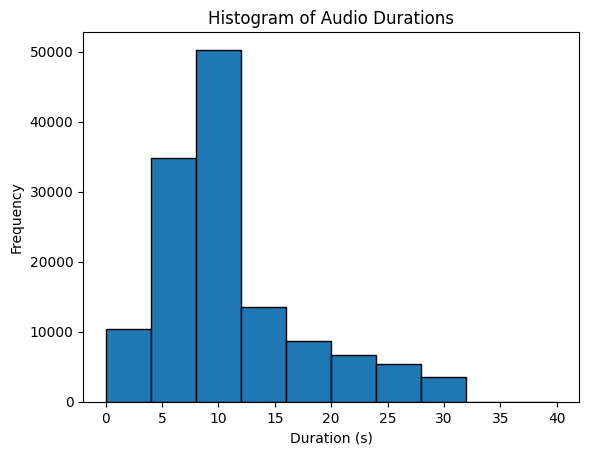

In [16]:
values = df_all_combined['duration']
list_range = (0, 40)

# values = df_all_combined['duration_segment']
# list_range = (0, 5)

# Plot histogram
plt.hist(values, bins=10, range=list_range, edgecolor='black')

# Add title and labels
plt.title('Histogram of Audio Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [17]:
df_all_combined.columns

Index(['label', 'duration', 'duration_segment', 'sample_frequency', 'mean',
       'variance', 'std_dev', 'max_value', 'min_value', 'rms', 'skewness',
       'kurtosis', 'median', 'range_val', 'iqr', 'zcr', 'energy', 'rmse',
       'entropy', 'spectral_centroid', 'spectral_bandwidth',
       'spectral_contrast', 'spectral_flatness', 'spectral_rolloff',
       'chroma_stft', 'mfcc_mean_1_mean', 'mfcc_mean_1_median', 'mfcc_1_std',
       'mfcc_mean_2_mean', 'mfcc_mean_2_median', 'mfcc_2_std',
       'mfcc_mean_3_mean', 'mfcc_mean_3_median', 'mfcc_3_std',
       'mfcc_mean_4_mean', 'mfcc_mean_4_median', 'mfcc_4_std',
       'mfcc_mean_5_mean', 'mfcc_mean_5_median', 'mfcc_5_std',
       'mfcc_mean_6_mean', 'mfcc_mean_6_median', 'mfcc_6_std',
       'mfcc_mean_7_mean', 'mfcc_mean_7_median', 'mfcc_7_std',
       'mfcc_mean_8_mean', 'mfcc_mean_8_median', 'mfcc_8_std',
       'mfcc_mean_9_mean', 'mfcc_mean_9_median', 'mfcc_9_std',
       'mfcc_mean_10_mean', 'mfcc_mean_10_median', 'mfcc_10_std